# How to access CMEMS data using Motu WCS API

Notes:

- Before accessing the WCS service, correct authentication needs to be established, see
   - https://github.com/clstoulouse/motu/issues/3
   - https://forum.marine.copernicus.eu/discussion/628/motu-rest-api

- Only NRT (Near Real Time) products are available via WCS (i.e. products with NRT in the name), see 
   - https://forum.marine.copernicus.eu/discussion/587/how-to-consume-webcoverageservice-wcs-via-motu-resolved
   - http://nrt.cmems-du.eu/motu-web/wcs?service=wcs&version=2.0.1&request=GetCapabilities

## Example WCS requests 

http://nrt.cmems-du.eu/motu-web/wcs?service=wcs&version=2.0.1&request=GetCapabilities

http://nrt.cmems-du.eu/motu-web/wcs?service=wcs&version=2.0.1&request=DescribeCoverage&coverageId=WIND_GLO_WIND_L3_NRT_OBSERVATIONS_012_002-TDS@KNMI-GLO-WIND_L3-OBS_METOP-B_ASCAT_25_DES_V2

http://nrt.cmems-du.eu/motu-web/wcs?service=WCS&version=2.0.1&request=GetCoverage&coverageId=WIND_GLO_WIND_L3_NRT_OBSERVATIONS_012_002-TDS@KNMI-GLO-WIND_L3-OBS_METOP-B_ASCAT_25_DES_V2&subset=Time(1451606400,1451606401)&subset=Lat(50,70)&subset=Lon(0,10)&rangeSubset=wind_speed

## Preparation

In [1]:
from owslib.wcs import WebCoverageService
from owslib.coverage.wcsBase import WCSCapabilitiesReader

from lxml import etree
import requests

from motu_utils.utils_cas import authenticate_CAS_for_URL
from motu_utils.utils_http import open_url

import xarray as xr
from matplotlib import pyplot as plt

In [2]:
# Set credentials from environment variables
UN_CMEMS = %env UN_CMEMS
PW_CMEMS = %env PW_CMEMS

In [3]:
# Define urls
url_service = 'http://nrt.cmems-du.eu/motu-web/wcs'
url_cas = 'https://cmems-cas.cls.fr/cas/login'
url_get_capabilities = 'http://nrt.cmems-du.eu/motu-web/wcs?service=wcs&version=2.0.1&request=GetCapabilities'
url_describe_coverage = 'http://nrt.cmems-du.eu/motu-web/wcs?service=wcs&version=2.0.1&request=DescribeCoverage&coverageId=WIND_GLO_WIND_L3_NRT_OBSERVATIONS_012_002-TDS@KNMI-GLO-WIND_L3-OBS_METOP-B_ASCAT_25_DES_V2'
url_get_coverage = 'http://nrt.cmems-du.eu/motu-web/wcs?service=WCS&version=2.0.1&request=GetCoverage&coverageId=WIND_GLO_WIND_L3_NRT_OBSERVATIONS_012_002-TDS@KNMI-GLO-WIND_L3-OBS_METOP-B_ASCAT_25_DES_V2&subset=Time(1451606400,1451606401)&subset=Lat(50,70)&subset=Lon(0,10)&rangeSubset=wind_speed'

## Authentication with session

In [4]:
# Does not work like this! Response is still the login page..

payload = {'username': UN_CMEMS,'password': PW_CMEMS}
with requests.Session() as session:
    # Login
    response = session.post(url_cas, data=payload)
    #print(response.text)
    # Get Capabilities
    response = session.get(url_get_capabilities)
    print(response.text)
    
    #cmems_wcs = WebCoverageService(url=url_service, version='2.0.1')
    #cmems_wcs.contents









<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">
	<head>
	    <title>Login</title>
		<link href="http://marine.copernicus.eu/favicon.ico" rel="shortcut icon" type="image/x-icon" />
		<!-- link rel="icon" type="image/png" href="http://myo-wp.techworks.ie/devel/templates/myocean/favicon.png" /-->>
	    <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />


		
		<link rel="stylesheet" type="text/css" href="/cas/newCss/css/myocean/screen/content.css" media="all" />
		<link rel="stylesheet" type="text/css" href="/cas/newCss/css/myocean/screen/content_cc.css" media="all" />
		<link rel="stylesheet" type="text/css" href="/cas/newCss/css/myocean/screen/patch_content_cc.css" media="all" />
		<link rel="stylesheet" type="text/css" href="/cas/newCss/css/cssmanager.php?version=4.0.2-1288885946&amp;files=/cas/newCss/css/myocean/print/print_003.css" media="print" />
		
	    <!--[if gte IE 6]><style type="text/css" 

## Using motu-client library

### Get Capabilities

In [5]:
# Get download url with ticket for authentication
download_url = authenticate_CAS_for_URL(url_get_capabilities, UN_CMEMS, PW_CMEMS)

# download_url is the original url appended with an additional request parameter "ticket"
# after one call to the download_url the ticket seems to expire

In [6]:
# Make request
response = open_url(download_url) # type http.client.HTTPResponse

In [7]:
# Read content
xml = response.read()
xml

b'<?xml version="1.0" encoding="UTF-8" standalone="yes"?>\n<ns3:Capabilities version="2.0.1" xmlns:ns6="http://www.opengis.net/swe/2.0" xmlns:ns5="http://www.opengis.net/gmlcov/1.0" xmlns:ns2="http://www.w3.org/1999/xlink" xmlns:ns1="http://www.opengis.net/ows/2.0" xmlns:ns4="http://www.opengis.net/gml/3.2" xmlns:ns3="http://www.opengis.net/wcs/2.0">\n    <ns1:ServiceIdentification>\n        <ns1:Title>Motu</ns1:Title>\n        <ns1:Abstract>Motu WCS service</ns1:Abstract>\n        <ns1:ServiceType>OGC WCS</ns1:ServiceType>\n        <ns1:ServiceTypeVersion>2.0.1</ns1:ServiceTypeVersion>\n        <ns1:Profile>http://www.opengis.net/spec/WCS/2.0/conf/core</ns1:Profile>\n        <ns1:Profile>http://www.opengis.net/spec/WCS_protocol-binding_get-kvp/1.0/conf/get-kvp</ns1:Profile>\n    </ns1:ServiceIdentification>\n    <ns1:OperationsMetadata>\n        <ns1:Operation name="GetCapabilities">\n            <ns1:DCP>\n                <ns1:HTTP>\n                    <ns1:Get ns2:href="http://nrt.

In [8]:
# Store xml as element tree
element_tree = etree.fromstring(xml)
element_tree

<Element {http://www.opengis.net/wcs/2.0}Capabilities at 0x7f169bd19b08>

### Get Coverage 

In [9]:
# Get download url with ticket for authentication
download_url = authenticate_CAS_for_URL(url_get_coverage, UN_CMEMS, PW_CMEMS)

# download_url is the original url appended with an additional request parameter "ticket"
# after one call to the download_url the ticket seems to expire

In [10]:
# Make request
response = open_url(download_url) # type http.client.HTTPResponse
bytes = response.read()           # type bytes

In [11]:
# Save as netCFD file

#with open('somefile.nc', 'wb') as f:
#    f.write(bytes)

#xr.open_dataset(bytes).to_netcdf("somefile.nc")

In [12]:
# Store data as xarray
array = xr.open_dataset(bytes)
array

<xarray.Dataset>
Dimensions:     (lat: 81, lon: 40, time: 1)
Coordinates:
  * time        (time) object 2016-01-01 00:00:00
  * lat         (lat) float32 50.125 50.375 50.625 ... 69.625 69.875 70.125
  * lon         (lon) float32 0.125 0.375 0.625 0.875 ... 9.375 9.625 9.875
Data variables:
    wind_speed  (time, lat, lon) float32 ...
Attributes:
    title:                            Global Ocean - Wind - METOP-B ASCAT - 2...
    title_short_name:                 ASCATB-L3-25km
    Conventions:                      CF-1.6
    institution:                      EUMETSAT/OSI SAF/KNMI
    source:                           MetOp-B ASCAT
    software_identification_level_1:  1000
    instrument_calibration_version:   0
    software_identification_wind:     3202
    pixel_size_on_horizontal:         25.0 km
    service_type:                     N/A
    processing_type:                  O
    contents:                         ovw
    granule_name:                     GLO-WIND_L3-OBS_METOP-B_ASCAT_25_DES_20...
    processing_level:                 L3
    orbit_number:                     43463
    start_date:                       2021-02-02
    start_time:                       00:00:00
    stop_date:                        2021-02-02
    stop_time:                        23:59:56
    equator_crossing_longitude:        343.148
    equator_crossing_date:            2021-02-01
    equator_crossing_time:            22:37:19
    rev_orbit_period:                 6081.7
    orbit_inclination:                98.7
    history:                          N/A
    references:                       ASCAT Wind Product User Manual, http://...
    comment:                          Orbit period and inclination are consta...
    creation_date:                    2021-02-03
    creation_time:                    05:02:46
    History:                          Translated to CF-1.0 Conventions by Net...
    geospatial_lat_min:               50.125
    geospatial_lat_max:               70.125
    geospatial_lon_min:               0.125
    geospatial_lon_max:               9.875

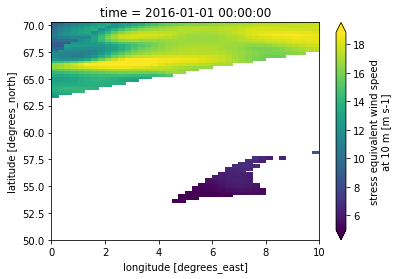

In [14]:
array.wind_speed.isel(time=0).plot(robust=True);